In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np
import os
import pickle
from google.colab import drive

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription", ("query", "target_y")
)
class FunctionFamily:
    SINE = "sine"
    EXP = "exp"
    POLYNOMIAL = "polynomial"
    STRAIGHT_LINE = "straight_line"

class CurvesReader:
    """Generates curves from various function families with mixed sampling."""

    def __init__(self, batch_size, max_num_context, testing=False):
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._testing = testing
        self._function_families = [
            FunctionFamily.SINE,
            FunctionFamily.EXP,
            FunctionFamily.POLYNOMIAL,
            FunctionFamily.STRAIGHT_LINE,
        ]

    def generate_curves(self, function_family=None):
        """Builds the op delivering the data with mixed function families."""

        # Sample number of context points
        num_context = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))

        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.linspace(start=-2, end=2, steps=num_target).unsqueeze(0).repeat(self._batch_size, 1).unsqueeze(-1)
        else:
            num_target = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))
            num_total_points = num_context + num_target
            x_values = (torch.rand((self._batch_size, num_total_points, 1))) * 4 - 2  # unif[-2, 2]

        # Randomly select function family if not specified
        if function_family is None:
            function_family = random.choice(self._function_families)

        # Generate different function types with random parameters
        if function_family == FunctionFamily.SINE:
            # Random amplitude (0.5-1.5), frequency (0.5-2.5), phase (0-2pi)
            amplitude = torch.rand(1) + 0.5
            frequency = torch.rand(1) * 2 + 0.5
            phase = torch.rand(1) * 2 * np.pi
            y_values = amplitude * torch.sin(frequency * x_values + phase)

        elif function_family == FunctionFamily.EXP:
            # Random scale (-0.5 to 0.5) and shift (-1 to 1)
            scale = torch.rand(1) - 0.5
            shift = torch.rand(1) * 2 - 1
            y_values = torch.exp(scale * x_values) + shift

        elif function_family == FunctionFamily.POLYNOMIAL:
            # Random quadratic coefficients (-1 to 1)
            coeffs = torch.rand(3) * 2 - 1
            y_values = coeffs[0] + coeffs[1] * x_values + coeffs[2] * x_values**2

        elif function_family == FunctionFamily.STRAIGHT_LINE:
            # Random slope (-1 to 1) and intercept (-2 to 2)
            slope = torch.rand(1) * 2 - 1
            intercept = torch.rand(1) * 4 - 2
            y_values = slope * x_values + intercept
        else:
            raise ValueError(f"Unknown function family: {function_family}")

        # Split into context and target points
        if self._testing:
            target_x = x_values
            target_y = y_values
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]
        else:
            target_x = x_values[:, : num_target + num_context, :]
            target_y = y_values[:, : num_target + num_context, :]
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)
        return CNPRegressionDescription(query=query, target_y=target_y), function_family

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Mount Google Drive (for saving datasets persistently)
drive.mount('/content/drive')


# Function families
class FunctionFamily:
    SINE = "sine"
    EXP = "exp"
    POLYNOMIAL = "polynomial"
    STRAIGHT_LINE = "straight_line"

function_families = [
    FunctionFamily.SINE,
    FunctionFamily.EXP,
    FunctionFamily.POLYNOMIAL,
    FunctionFamily.STRAIGHT_LINE,
]

# Dataset configuration
DATASET_NAME = "fixed_cnp_dataset.pkl"  # Single file for all datasets
DATASET_PATH = f"/content/drive/MyDrive/{DATASET_NAME}"

# =============================================
# Dataset Management
# =============================================
def generate_fixed_datasets():
    """Generate new fixed datasets for all function families"""
    print("Generating new fixed datasets...")

    test_readers = {
        family: CurvesReader(TEST_BATCH_SIZE, MAX_CONTEXT_POINTS, testing=True)
        for family in function_families
    }

    fixed_datasets = {}
    for family in function_families:
        fixed_datasets[family] = [
            test_readers[family].generate_curves(family)[0]
            for _ in range(NUM_TEST_TASKS)
        ]
        print(f"Generated {len(fixed_datasets[family])} tasks for {family}")

    return fixed_datasets

def save_datasets(datasets):
    """Save datasets to Google Drive"""
    with open(DATASET_PATH, 'wb') as f:
        pickle.dump({
            'creation_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'parameters': {
                'test_batch_size': TEST_BATCH_SIZE,
                'max_context_points': MAX_CONTEXT_POINTS,
                'num_test_tasks': NUM_TEST_TASKS
            },
            'data': datasets
        }, f)
    print(f"Saved fixed datasets to {DATASET_PATH}")

def load_datasets():
    """Load datasets from Google Drive"""
    if not os.path.exists(DATASET_PATH):
        return None

    with open(DATASET_PATH, 'rb') as f:
        data = pickle.load(f)
        print(f"Loaded fixed datasets created on {data['creation_date']}")
        return data['data']

# Load or create fixed datasets
fixed_test_datasets = load_datasets()

if fixed_test_datasets is None:
    fixed_test_datasets = generate_fixed_datasets()
    save_datasets(fixed_test_datasets)
else:
    print("Using existing fixed datasets")


Mounted at /content/drive
Generating new fixed datasets...


NameError: name 'TEST_BATCH_SIZE' is not defined

In [ ]:
# Dataset configuration
DATASET_NAME = "fixed_cnp_dataset.pkl"  # Single file for all datasets
DATASET_PATH = f"/content/{DATASET_NAME}"
# =============================================
def generate_fixed_datasets():
    """Generate new fixed datasets for all function families"""
    print("Generating new fixed datasets...")

    test_readers = {
        family: CurvesReader(TEST_BATCH_SIZE, MAX_CONTEXT_POINTS, testing=True)
        for family in function_families
    }

    fixed_datasets = {}
    for family in function_families:
        fixed_datasets[family] = [
            test_readers[family].generate_curves(family)[0]
            for _ in range(NUM_TEST_TASKS)
        ]
        print(f"Generated {len(fixed_datasets[family])} tasks for {family}")

    return fixed_datasets

def save_datasets(datasets):
    """Save datasets to Google Drive"""
    with open(DATASET_PATH, 'wb') as f:
        pickle.dump({
            'creation_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'parameters': {
                'test_batch_size': TEST_BATCH_SIZE,
                'max_context_points': MAX_CONTEXT_POINTS,
                'num_test_tasks': NUM_TEST_TASKS
            },
            'data': datasets
        }, f)
    print(f"Saved fixed datasets to {DATASET_PATH}")

def load_datasets():
    """Load datasets from Google Drive"""
    if not os.path.exists(DATASET_PATH):
        return None

    with open(DATASET_PATH, 'rb') as f:
        data = pickle.load(f)
        print(f"Loaded fixed datasets created on {data['creation_date']}")
        return data['data']

# Load or create fixed datasets
fixed_test_datasets = load_datasets()

if fixed_test_datasets is None:
    fixed_test_datasets = generate_fixed_datasets()
    save_datasets(fixed_test_datasets)
else:
    print("Using existing fixed datasets")

Loaded fixed datasets created on 2025-04-13 19:09:56
Using existing fixed datasets


Starting training at 2025-04-14 10:13:25

Iteration: 500
  sine: MSE = 0.6143
  exp: MSE = 0.1524
  polynomial: MSE = 1.0905
  straight_line: MSE = 0.4563
  Average MSE: 0.5783

Iteration: 1000
  sine: MSE = 0.5897
  exp: MSE = 0.1481
  polynomial: MSE = 1.0630
  straight_line: MSE = 0.4146
  Average MSE: 0.5538

Iteration: 1500
  sine: MSE = 0.5680
  exp: MSE = 0.1507
  polynomial: MSE = 1.0514
  straight_line: MSE = 0.4190
  Average MSE: 0.5473

Iteration: 2000
  sine: MSE = 0.5222
  exp: MSE = 0.1049
  polynomial: MSE = 0.9726
  straight_line: MSE = 0.3395
  Average MSE: 0.4848

Iteration: 2500
  sine: MSE = 0.4930
  exp: MSE = 0.0901
  polynomial: MSE = 0.8923
  straight_line: MSE = 0.2470
  Average MSE: 0.4306

Iteration: 3000
  sine: MSE = 0.4416
  exp: MSE = 0.0580
  polynomial: MSE = 0.7956
  straight_line: MSE = 0.1479
  Average MSE: 0.3608

Iteration: 3500
  sine: MSE = 0.4356
  exp: MSE = 0.0609
  polynomial: MSE = 0.7690
  straight_line: MSE = 0.1268
  Average MSE: 0.3481



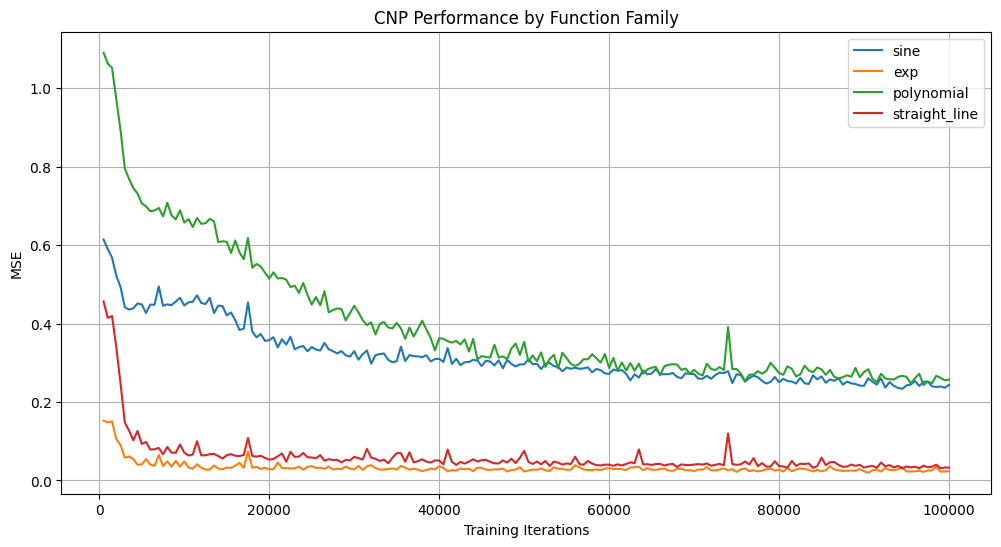

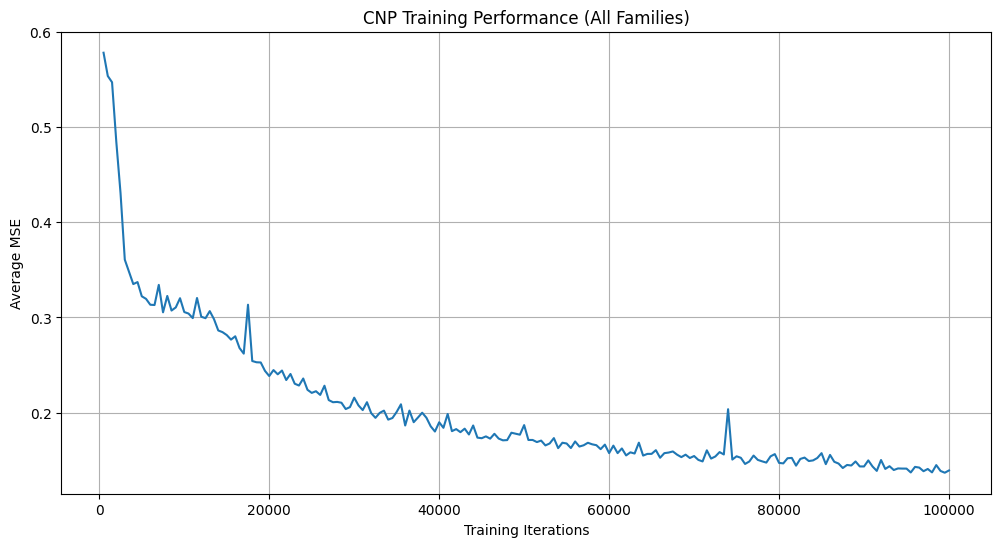


Final Evaluation and Visualization:


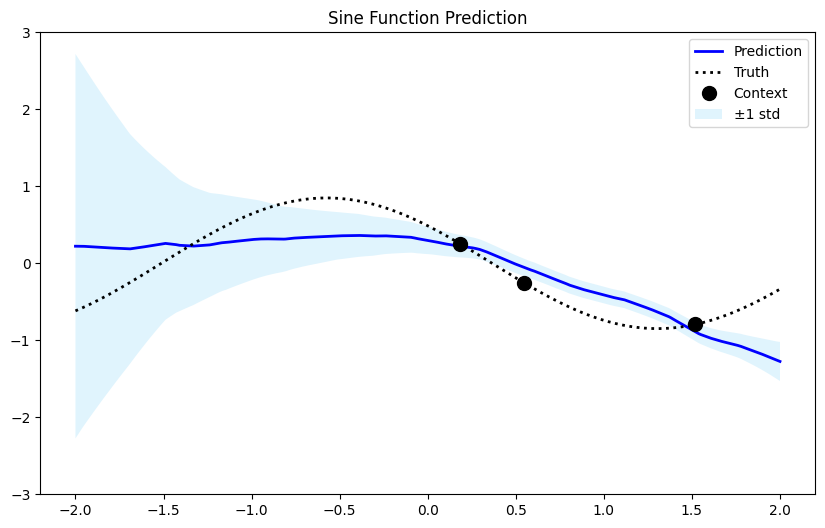

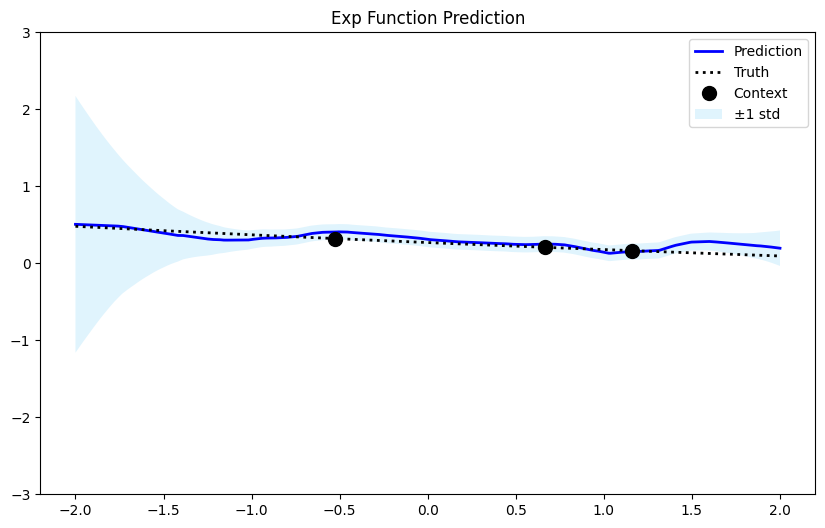

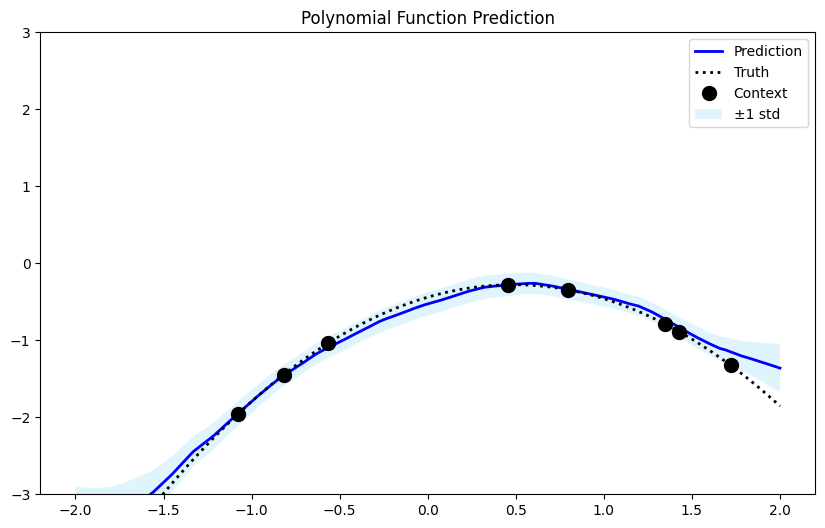

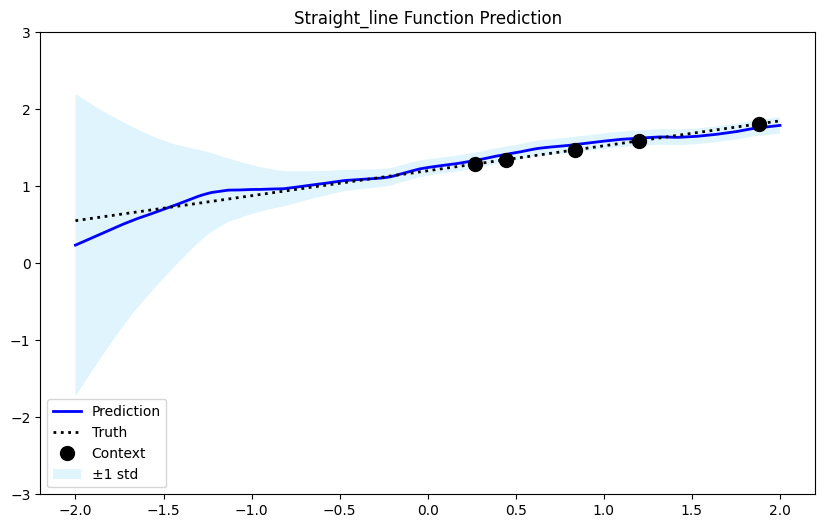

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np


class DeterministicEncoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicEncoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, context_x, context_y):
        encoder_input = torch.cat((context_x, context_y), dim=-1)
        batch_size, set_size, filter_size = encoder_input.shape
        x = encoder_input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        x = x.view(batch_size, set_size, -1)
        representation = x.mean(dim=1)
        return representation

class DeterministicDecoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicDecoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, representation, target_x):
        batch_size, set_size, d = target_x.shape
        representation = representation.unsqueeze(1).repeat([1, set_size, 1])
        input = torch.cat((representation, target_x), dim=-1)
        x = input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        out = x.view(batch_size, set_size, -1)
        mu, log_sigma = torch.split(out, 1, dim=-1)
        sigma = 0.1 + 0.9 * torch.nn.functional.softplus(log_sigma)
        dist = torch.distributions.normal.Normal(loc=mu, scale=sigma)
        return dist, mu, sigma

class DeterministicModel(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        super(DeterministicModel, self).__init__()
        self._encoder = DeterministicEncoder(encoder_sizes)
        self._decoder = DeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        (context_x, context_y), target_x = query
        representation = self._encoder(context_x, context_y)
        dist, mu, sigma = self._decoder(representation, target_x)
        log_p = None if target_y is None else dist.log_prob(target_y)
        return log_p, mu, sigma

def plot_functions(target_x, target_y, context_x, context_y, pred_y, var, title=""):
    """Plots the predicted mean and variance and the context points."""
    plt.figure(figsize=(10, 6))
    plt.plot(target_x[0].squeeze(), pred_y[0].squeeze(), "b", linewidth=2, label='Prediction')
    plt.plot(target_x[0].squeeze(), target_y[0].squeeze(), "k:", linewidth=2, label='Truth')
    plt.plot(context_x[0].squeeze(), context_y[0].squeeze(), "ko", markersize=10, label='Context')
    plt.fill_between(
        target_x[0].squeeze(),
        (pred_y[0] - var[0]).squeeze(),
        (pred_y[0] + var[0]).squeeze(),
        alpha=0.2,
        facecolor="#65c9f7",
        interpolate=True,
        label='±1 std'
    )
    plt.legend()
    plt.ylim([-3, 3])
    plt.title(title)
    plt.show()

# Hyperparameters
TRAINING_ITERATIONS = int(1e5)
EVAL_AFTER = 500
MAX_CONTEXT_POINTS = 10
BATCH_SIZE = 64
TEST_BATCH_SIZE = 100
NUM_TEST_TASKS = 100


d_x, d_in, representation_size, d_out = 1, 2, 128, 2
encoder_sizes = [d_in, 128, 128, 128, representation_size]
decoder_sizes = [representation_size + d_x, 128, 128, 2]
model = DeterministicModel(encoder_sizes, decoder_sizes)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training statistics
mse_values = []
training_tasks = []
family_mses = {family: [] for family in function_families}

def evaluate_model(model, test_datasets, family_name=None):
    """Evaluates the model on fixed test datasets"""
    model.eval()
    total_mse = 0.0
    with torch.no_grad():
        for data_test in test_datasets:
            _, pred_y, _ = model(data_test.query, data_test.target_y)
            mse = torch.mean((pred_y - data_test.target_y)**2)
            total_mse += mse.item()
    model.train()
    avg_mse = total_mse / len(test_datasets)
    if family_name:
        print(f"  {family_name}: MSE = {avg_mse:.4f}")
    return avg_mse

# Training loop
print(f"Starting training at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
train_reader = CurvesReader(BATCH_SIZE, MAX_CONTEXT_POINTS, testing=False)

for it in range(TRAINING_ITERATIONS):
    # Training step (using random families)
    data_train, _ = train_reader.generate_curves()
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()

    # Evaluation
    if (it + 1) % EVAL_AFTER == 0:
        print(f"\nIteration: {it + 1}")
        total_mse = 0.0
        for family in function_families:
            family_mse = evaluate_model(model, fixed_test_datasets[family], family)
            family_mses[family].append(family_mse)
            total_mse += family_mse

        avg_mse = total_mse / len(function_families)
        mse_values.append(avg_mse)
        training_tasks.append(it + 1)
        print(f"  Average MSE: {avg_mse:.4f}")


# Plot training curves
plt.figure(figsize=(12, 6))
for family in function_families:
    plt.plot(training_tasks, family_mses[family], label=family)
plt.xlabel('Training Iterations')
plt.ylabel('MSE')
plt.title('CNP Performance by Function Family')
plt.legend()
plt.grid(True)
plt.show()

# Plot overall training curve
plt.figure(figsize=(12, 6))
plt.plot(training_tasks, mse_values)
plt.xlabel('Training Iterations')
plt.ylabel('Average MSE')
plt.title('CNP Training Performance (All Families)')
plt.grid(True)
plt.show()

# Visualize predictions for each function family
print("\nFinal Evaluation and Visualization:")
test_reader = CurvesReader(1, MAX_CONTEXT_POINTS, testing=True)
for family in function_families:
    data_test, _ = test_reader.generate_curves(family)
    with torch.no_grad():
        _, pred_y, var = model(data_test.query, data_test.target_y)
        (context_x, context_y), target_x = data_test.query
        plot_functions(
            target_x.detach().numpy(),
            data_test.target_y.detach().numpy(),
            context_x.detach().numpy(),
            context_y.detach().numpy(),
            pred_y.detach().numpy(),
            var.detach().numpy(),
            title=f"{family.capitalize()} Function Prediction"
        )